# 신용카드 사용자 연체 예측

* 모델링 후 Partia Dependence Plot 활용해보기




### 데이터 설명(출처: Dacon)
index


gender: 성별


car: 차량 소유 여부


reality: 부동산 소유 여부


child_num: 자녀 수


income_total: 연간 소득


income_type: 소득 분류


							['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']



edu_type: 교육 수준


							['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']



family_type: 결혼 여부


							['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']



house_type: 생활 방식


							['Municipal apartment', 'House / apartment', 'With parents',

							

							 'Co-op apartment', 'Rented apartment', 'Office apartment']



DAYS_BIRTH: 출생일


							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미



DAYS_EMPLOYED: 업무 시작일


							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미

													

							양수 값은 고용되지 않은 상태를 의미함



FLAG_MOBIL: 핸드폰 소유 여부


work_phone: 업무용 전화 소유 여부


phone: 전화 소유 여부


email: 이메일 소유 여부


occyp_type: 직업 유형													


family_size: 가족 규모


begin_month: 신용카드 발급 월
			

							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미







credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도(Target)


							=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# 전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 데이터 분할
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV

# 모델링
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# 평가지표
from sklearn.metrics import accuracy_score, mean_squared_error

In [2]:
train=pd.read_csv('train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [4]:
train.head(3)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0


# Preprocessing

#### (이중분류 학습을 위해) credit 이 2.0 인거 제외 

In [5]:
tr1=train[train['credit']!=2.0]

In [6]:
tr1['credit'].value_counts()

1.0    6267
0.0    3222
Name: credit, dtype: int64

#### 변수별 상관도 확인

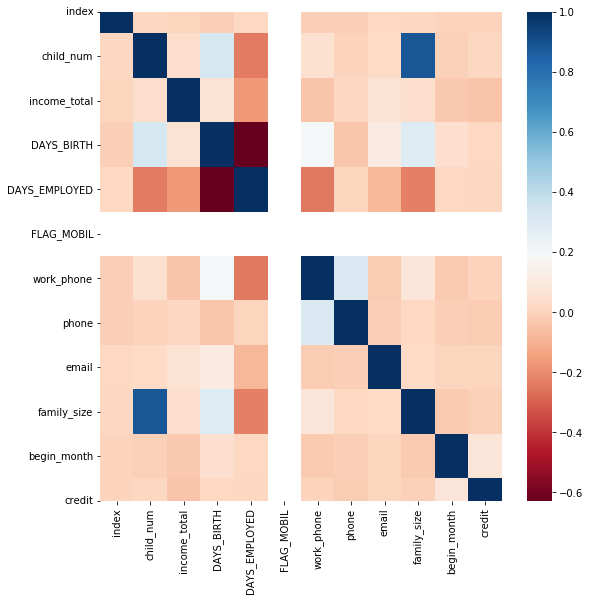

In [7]:
plt.figure(figsize=(9,9))
corr = tr1.corr()
sns.heatmap(corr,cmap='RdBu')

child_num / family_size 
days_birth / days_employed 
### 상관계수가 0.5이상이면 상관관계가 있다고 판단하여 둘 중 하나 삭제

In [8]:
tr1 = tr1.drop(['child_num','DAYS_BIRTH'],axis=1)

### 신용카드 발급 월 및 업무 시작일 변경 begin_month -> worked_year

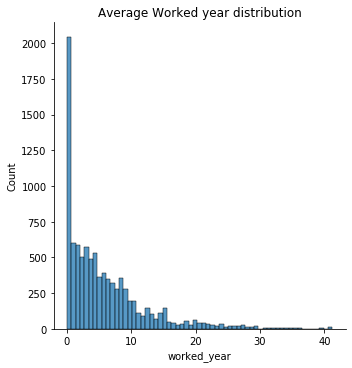

In [9]:
# 신용카드 발급 월 변경: worked_year
tr1['worked_year'] = [0 if s >=0 else round(abs(s)/12, 2) for s in tr1['begin_month']]

# 업무 시작일 변경: worked_year
tr1['worked_year'] = [0 if s >=0 else round(abs(s)/365.5,2) for s in tr1['DAYS_EMPLOYED']]
sns.displot(data=tr1,x="worked_year",kind='hist')
plt.title('Average Worked year distribution')
plt.show()

### 결측치 제거

In [10]:
# occyp_type 결측치 확인
tr1.isnull().sum()

index               0
gender              0
car                 0
reality             0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       2905
family_size         0
begin_month         0
credit              0
worked_year         0
dtype: int64

In [11]:
tr1['occyp_type'].value_counts()

Laborers                 1668
Core staff                969
Sales staff               943
Managers                  738
Drivers                   545
High skill tech staff     393
Accountants               345
Medicine staff            274
Cooking staff             168
Cleaning staff            133
Security staff            127
Private service staff      90
Waiters/barmen staff       60
Low-skill Laborers         43
Secretaries                40
Realty agents              19
IT staff                   18
HR staff                   11
Name: occyp_type, dtype: int64

In [12]:
# days_employed가 양수인 경우 무직으로 판단 (2905개 중 1620개) 
# -> occyp_type을 무직으로 분류
ocp=tr1[tr1['occyp_type'].isnull()]
ocp[ocp['DAYS_EMPLOYED']>0]

,index,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,worked_year
60,60,M,Y,Y,112500.0,Pensioner,Secondary / secondary special,Separated,House / apartment,365243,1,0,0,0,NaN,1.0,-1.0,1.0,0.0
120,120,F,N,Y,157500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,365243,1,0,0,0,NaN,1.0,-4.0,1.0,0.0
138,138,F,N,Y,54000.0,Pensioner,Secondary / secondary special,Married,House / apartment,365243,1,0,0,0,NaN,2.0,-2.0,0.0,0.0
159,159,F,N,Y,153000.0,Pensioner,Higher education,Married,House / apartment,365243,1,0,1,0,NaN,2.0,-51.0,1.0,0.0
173,173,F,N,Y,189000.0,Pensioner,Secondary / secondary special,Married,House / apartment,365243,1,0,0,0,NaN,2.0,-19.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26401,26401,F,Y,Y,225000.0,Pensioner,Secondary / secondary special,Married,House / apartment,365243,1,0,0,0,NaN,2.0,-41.0,1.0,0.0
26406,26406,F,N,Y,144000.0,Pensioner,Secondary / secondary special,Married,House / apartment,365243,1,0,1,0,NaN,2.0,-3.0,1.0,0.0
26431,26431,F,N,Y,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,365243,1,0,0,1,NaN,1.0,-60.0,1.0,0.0
26432,26432,F,Y,Y,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,365243,1,0,1,0,NaN,2.0,-17.0,1.0,0.0


In [13]:
# cccyp_type 무직 범주 생성
ocp['occyp_type']=['inoccupation' if s>0 else 'null' for s in ocp['DAYS_EMPLOYED']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
ocp['occyp_type'].value_counts()
ocp=ocp[ocp['occyp_type']=='inoccupation'] #1620

In [15]:
# 원래 데이터에서 결측치 제거
tr1=tr1.dropna(axis=0) #6584

In [16]:
# 직업유형이 무직인 데이터 셋 붙이기
tr1=pd.concat([tr1,ocp]) 
tr1 #8204

,index,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,worked_year
1,1,F,N,Y,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,4.21
3,3,F,N,Y,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,5.72
5,5,F,N,Y,270000.0,Working,Secondary / secondary special,Married,House / apartment,-4996,1,0,0,1,High skill tech staff,4.0,-18.0,1.0,13.67
7,7,M,N,Y,270000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-5420,1,0,0,1,Drivers,2.0,-53.0,0.0,14.83
12,12,F,Y,Y,157500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-2162,1,0,0,0,Accountants,3.0,-60.0,0.0,5.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26401,26401,F,Y,Y,225000.0,Pensioner,Secondary / secondary special,Married,House / apartment,365243,1,0,0,0,inoccupation,2.0,-41.0,1.0,0.00
26406,26406,F,N,Y,144000.0,Pensioner,Secondary / secondary special,Married,House / apartment,365243,1,0,1,0,inoccupation,2.0,-3.0,1.0,0.00
26431,26431,F,N,Y,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,365243,1,0,0,1,inoccupation,1.0,-60.0,1.0,0.00
26432,26432,F,Y,Y,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,365243,1,0,1,0,inoccupation,2.0,-17.0,1.0,0.00


변경한 기존 컬럼 삭제

In [17]:
tr1=tr1.drop(['DAYS_EMPLOYED','begin_month'],axis=1)

휴대폰 및 이메일 관련 변수 삭제

In [18]:
tr1= tr1.drop([ 'FLAG_MOBIL', 'work_phone', 'phone', 'email'],axis=1)

### Target Under Sampling

In [19]:
!pip install -U imbalanced-learn

In [20]:
from imblearn.under_sampling import *
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
import imblearn
print(imblearn.__version__)

0.8.1


In [22]:
data = tr1.values
data

array([[1, 'F', 'N', ..., 3.0, 1.0, 4.21],
       [3, 'F', 'N', ..., 2.0, 0.0, 5.72],
       [5, 'F', 'N', ..., 4.0, 1.0, 13.67],
       ...,
       [26431, 'F', 'N', ..., 1.0, 1.0, 0.0],
       [26432, 'F', 'Y', ..., 2.0, 1.0, 0.0],
       [26443, 'F', 'N', ..., 1.0, 1.0, 0.0]], dtype=object)

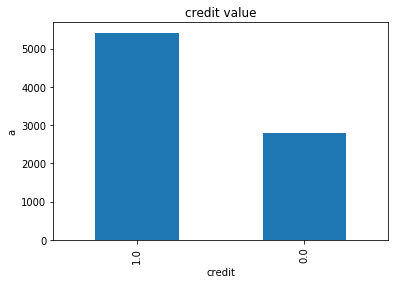

In [23]:
# 데이터 불균형 확인
pd.value_counts(tr1['credit']).plot.bar()
plt.title('credit value')
plt.xlabel('credit')
plt.ylabel('a')
plt.show()

In [24]:
count_class_1, count_class_0 = tr1.credit.value_counts()
count_class_1

5413

In [25]:
df_class_0 = tr1[tr1['credit'] == 0]
df_class_1 = tr1[tr1['credit'] == 1]

In [26]:
df_class_1_under = df_class_1.sample(count_class_0)
df_under = pd.concat([df_class_1_under, df_class_0], axis=0)
print('Random Under-Sampling :')
print(df_under.credit.value_counts())

Random Under-Sampling :
0.0    2791
1.0    2791
Name: credit, dtype: int64


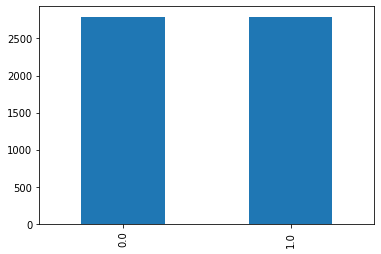

In [27]:
pd.value_counts(df_under['credit']).plot.bar()
plt.show()

### Encoding

In [28]:
numerical_feats = df_under.dtypes[df_under.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_under.dtypes[df_under.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  4
Number of Categorical features:  8


In [29]:
numerical_feats

['index', 'income_total', 'family_size', 'worked_year']

In [30]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

In [31]:
for i in categorical_feats:
    df_under[[i]] = df_under[[i]].apply(LabelEncoder().fit_transform)

In [32]:
#shape확인 
# target 제외 변수 12개
nData = df_under.shape[0]
nVar = df_under.shape[1]
print('데이터개수 : %d' % nData, '변수개수: %d' % nVar)

데이터개수 : 5582 변수개수: 13


In [33]:
# feature/target, train/test dataset 분리

feature_columns = list(df_under.columns.difference(['credit']))
X = df_under[feature_columns]
y = df_under['credit']

#학습데이터와 평가데이터의 비율을 8:2로 분할
# random_state 는 값 고정(숫자 노상관)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_val.shape, y_val.shape, y_val.shape)

(4465, 12) (1117, 12) (1117,) (1117,)


# 기본 모델링

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, log_loss

### Random Forest

In [35]:
#기본 랜덤포레스트 
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)
rf_preds = rf.predict_proba(X_val)

In [36]:
print(log_loss(y_val, rf_preds))

0.6387004958317964


### XGBoost

In [37]:
#기본 xgb
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict_proba(X_val)

In [38]:
print(log_loss(y_val, xgb_preds))

0.6735010356538085


### lightGBM

In [39]:
lgb = LGBMClassifier(random_state=0)
lgb.fit(X_train, y_train)
lgb_preds= lgb.predict_proba(X_val)

In [40]:
print(log_loss(y_val, lgb_preds))

0.6589044679542091


# 파라미터 튜닝

In [41]:
!pip install bayesian-optimization

In [42]:
from bayes_opt import BayesianOptimization

### XGBoost

In [43]:
# xgb
evals = [(X_train, y_train), (X_val, y_val)]

def xgb_evaluate(max_depth, colsample_bytree, learning_rate, n_estimators):
    xgb = XGBClassifier(max_depth=int(max_depth), colsample_bytree=colsample_bytree,
                        learning_rate=learning_rate, n_estimators=int(n_estimators),
                        eval_metric='logloss', verbosity=0, random_state=0, n_jobs=-1)
    xgb.fit(X_train, y_train, eval_set=evals, early_stopping_rounds=50)
    xgb_pred_proba = xgb.predict_proba(X_val)[:, 1]
    
    return log_loss(y_val, xgb_preds)

In [44]:
xgbBO = BayesianOptimization(xgb_evaluate, {'max_depth': (5, 20), 'colsample_bytree': (0.7, 1.0), 'learning_rate': (0.05, 0.1), 'n_estimators': (500, 1500)})

In [45]:
xgbBO.maximize(n_iter=10, init_points=2)
print(xgbBO.max)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
[0]	validation_0-logloss:0.684741	validation_1-logloss:0.689211
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.677771	validation_1-logloss:0.687449
[2]	validation_0-logloss:0.67062	validation_1-logloss:0.685063
[3]	validation_0-logloss:0.663684	validation_1-logloss:0.683213
[4]	validation_0-logloss:0.658179	validation_1-logloss:0.68115
[5]	validation_0-logloss:0.65326	validation_1-logloss:0.67947
[6]	validation_0-logloss:0.648891	validation_1-logloss:0.677471
[7]	validation_0-logloss:0.644718	validation_1-logloss:0.676808
[8]	validation_0-logloss:0.642482	validation_1-logloss:0.675691
[9]	validation_0-logloss:0.639706	validation_1-logloss:0.675191
[10]	validation_0-logloss:0.636967	validation_1-log

In [46]:
xgb2 = XGBClassifier(max_depth=int(17.70500506757619), colsample_bytree=0.9001911033571635,
                        learning_rate=0.09420108796265733, n_estimators=int(1065.0106295869248),
                        eval_metric='logloss', verbosity=0, random_state=0, n_jobs=-1)
xgb2.fit(X_train, y_train, eval_set=evals, early_stopping_rounds=50)
xgb2_pred_proba = xgb.predict_proba(X_val)[:, 1]

[0]	validation_0-logloss:0.660679	validation_1-logloss:0.682409
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.638239	validation_1-logloss:0.676789
[2]	validation_0-logloss:0.614936	validation_1-logloss:0.674264
[3]	validation_0-logloss:0.594048	validation_1-logloss:0.672435
[4]	validation_0-logloss:0.574244	validation_1-logloss:0.667364
[5]	validation_0-logloss:0.557685	validation_1-logloss:0.665526
[6]	validation_0-logloss:0.540427	validation_1-logloss:0.656051
[7]	validation_0-logloss:0.521888	validation_1-logloss:0.653423
[8]	validation_0-logloss:0.508313	validation_1-logloss:0.649545
[9]	validation_0-logloss:0.491916	validation_1-logloss:0.646891
[10]	validation_0-logloss:0.47728	validation_1-logloss:0.645229
[11]	validation_0-logloss:0.467423	validation_1-logloss:0.64627
[12]	validation_0-logloss:0.458345	validation_1-logloss:0.643933
[1

# Partial Dependece Plot(PDP)

In [47]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


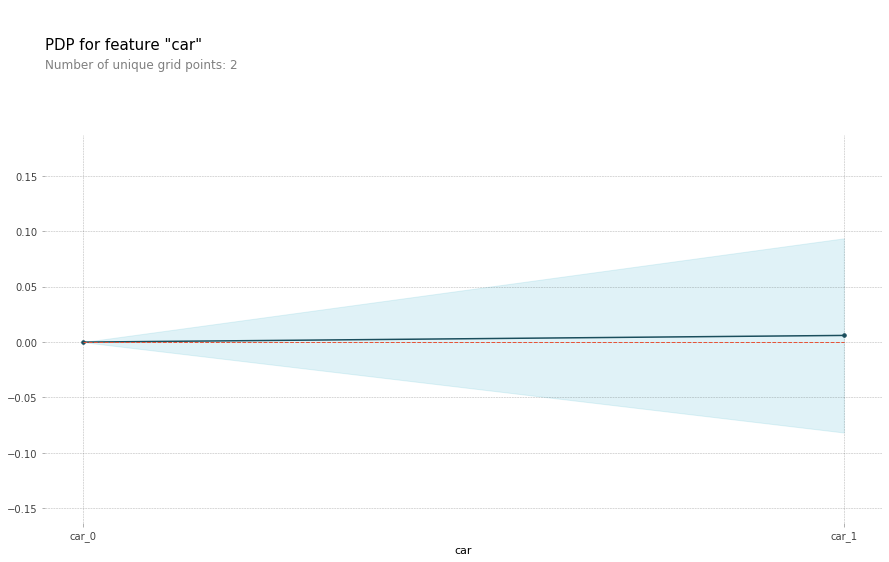

In [48]:
selected_feature = 'car'
pdp_dist = pdp_isolate(
    model=xgb2,
    dataset=X_val,
    model_features=X_val.columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

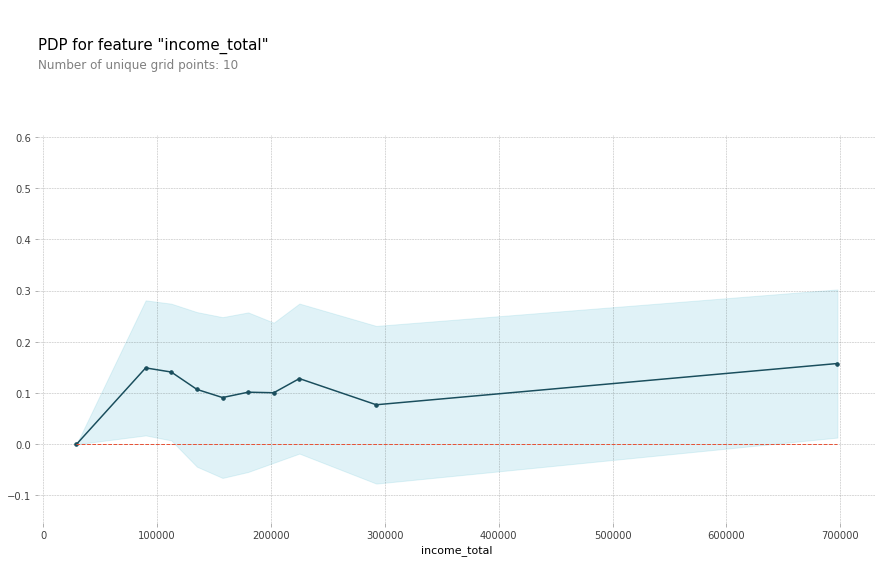

In [49]:
selected_feature = 'income_total'
pdp_dist = pdp_isolate(
    model=xgb2,
    dataset=X_val,
    model_features=X_val.columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

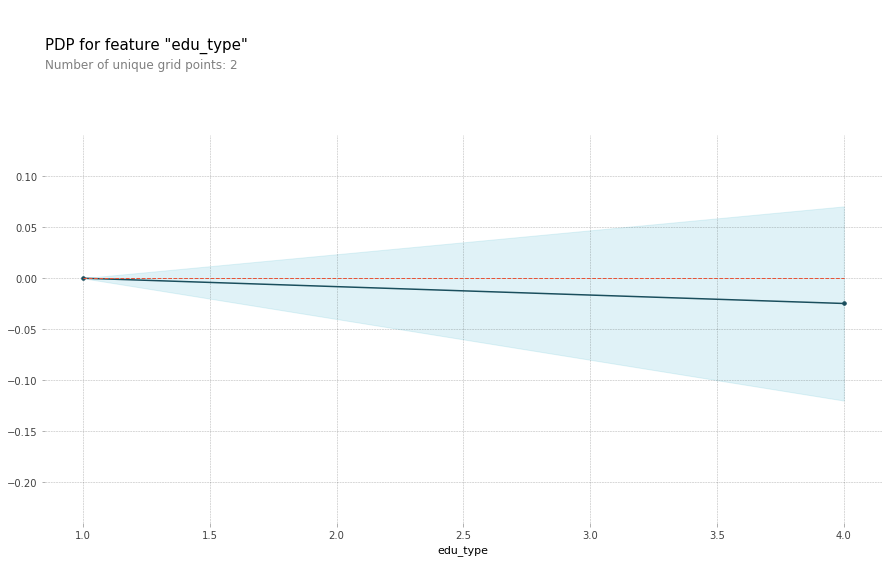

In [50]:
selected_feature = 'edu_type'
pdp_dist = pdp_isolate(
    model=xgb2,
    dataset=X_val,
    model_features=X_val.columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

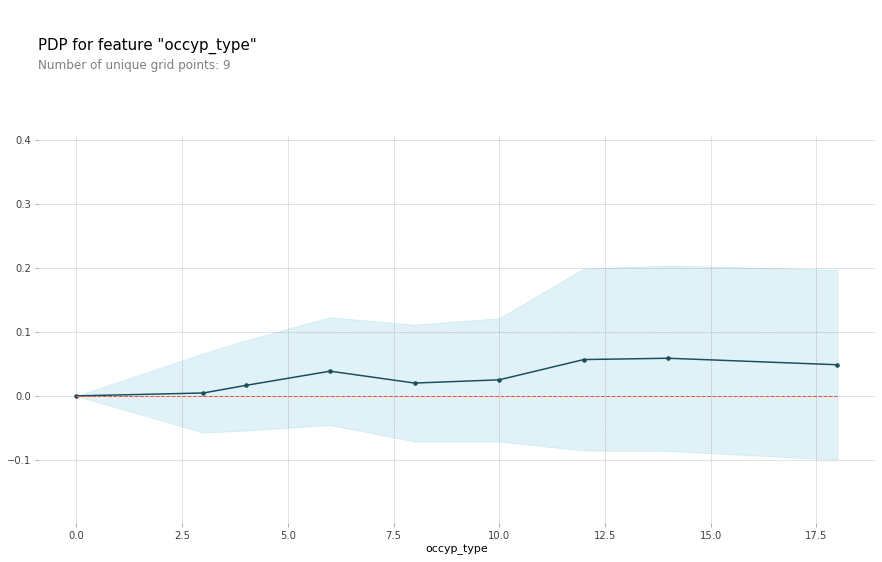

In [51]:
selected_feature = 'occyp_type'
pdp_dist = pdp_isolate(
    model=xgb2,
    dataset=X_val,
    model_features=X_val.columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

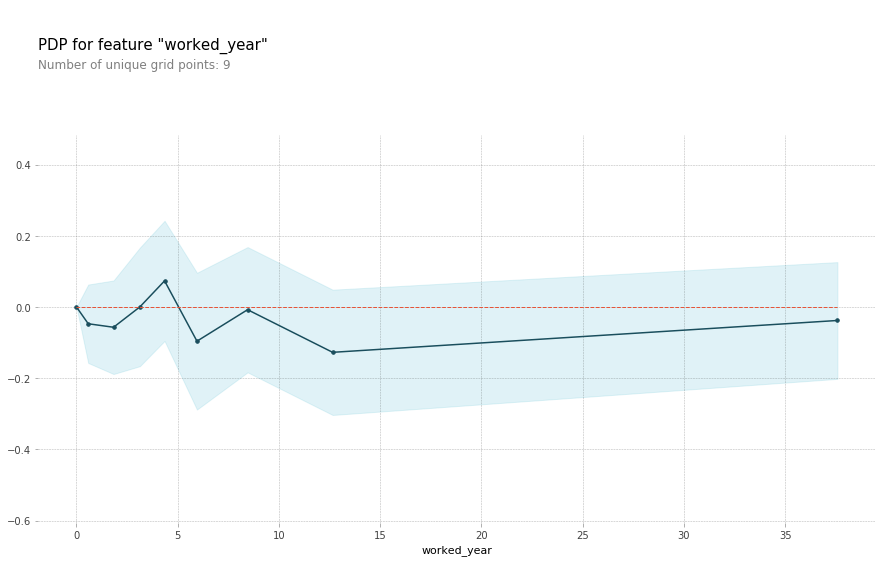

In [54]:
selected_feature = 'worked_year'
pdp_dist = pdp_isolate(
    model=xgb2,
    dataset=X_val,
    model_features=X_val.columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);